# Colab notebooks remark

In [ ]:
import keras
print('Keras version:', keras.__version__)
import tensorflow
print('Tensorflow version:', tensorflow.__version__)

if tensorflow.test.gpu_device_name():
  print('Default GPU Device: {}'.format(tensorflow.test.gpu_device_name()))
else:
  print("Please install GPU version of TF")

Keras version: 2.12.0
Tensorflow version: 2.12.0
Default GPU Device: /device:GPU:0


**Note**: make sure you connect this notebook to a GPU. To do so, please go to main menu and click "Edit" -> "Notebook settings". In the dialog, select "GPU" in the "Hardware accelerator" dropdown menu. Don't forget to save the settings. When you see in the upper right corner that your notebook is connected (dropdown menu besides the editing menu) you are ready to go.

**Origin**: This Colab notebook is based on [this](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb) Jupyter notebook at GitHub.

# Understanding recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

[...]

## A first recurrent layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [ ]:
from tensorflow.keras.layers import SimpleRNN

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence like 
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential()
model.add(Embedding(10000, 8)) # parameter max_length not required, because no flattening needed (using RNN layer now, not Dense layer)
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           80000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1312      
                                                                 
Total params: 81,312
Trainable params: 81,312
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()
model.add(Embedding(10000, 8))
model.add(SimpleRNN(32, return_sequences=True)) # Returns 3D tensor preserving sequence
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 8)           80000     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          1312      
                                                                 
Total params: 81,312
Trainable params: 81,312
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [ ]:
model = Sequential()
model.add(Embedding(10000, 8))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 8)           80000     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          1312      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 87,585
Trainable params: 87,585
Non-trai

Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)


print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
17464789/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [ ]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32, input_length=maxlen))
model.add(SimpleRNN(32, unroll=True))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(input_train, y_train,
                    verbose=1,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 32)           320000    
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 67s 231ms/step - loss: 0.6385 - acc: 0.6230 - val_loss: 0.4847 - val_acc: 0.7844
Epoch 2/10
157/157 [==============================] - 24s 154ms/step - loss: 0.4278 - acc: 0.8184 - val_loss: 0.4889 - val_acc: 0.7694
Epoch 3/10
157/157 [======================

Let's display the training and validation loss and accuracy:

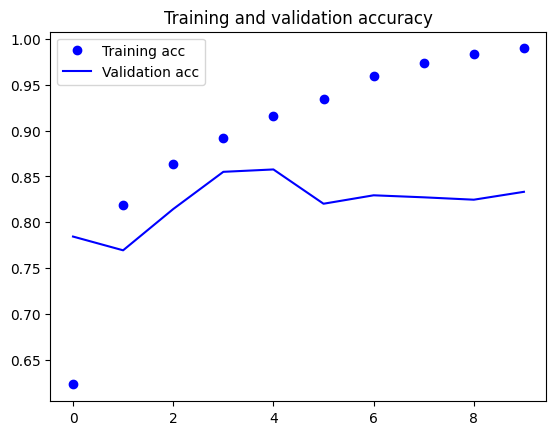

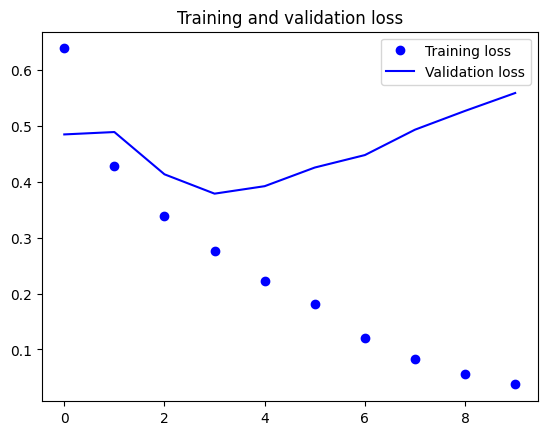

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers further below like LSTM layers.

But first train a model with all the training data and evaluate on test data.

In [ ]:
model = Sequential()
model.add(Embedding(max_features, 32, input_length=maxlen))
model.add(SimpleRNN(32, unroll=True))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(input_train, y_train,
                    epochs=4,
                    batch_size=128)

print('\nEvaluate on test data')
results = model.evaluate(input_test, y_test)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 32)           320000    
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
196/196 [==============================] - 56s 160ms/step - loss: 0.5449 - acc: 0.7160
Epoch 2/4
196/196 [==============================] - 24s 123ms/step - loss: 0.3485 - acc: 0.8560
Epoch 3/4
196/196 [==============================] - 22s 113ms/step - loss: 0.2807 - acc: 0.8908
Epoch 4/4
196/196 [==

[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [ ]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 24s 134ms/step - loss: 0.5924 - acc: 0.6737 - val_loss: 0.4115 - val_acc: 0.8278
Epoch 2/10
157/157 [==============================] - 17s 105ms/step - loss: 0.3506 - acc: 0.8567 - val_loss: 0.3167 - val_acc: 0.8702
Epoch 3/10
157/157 [======================

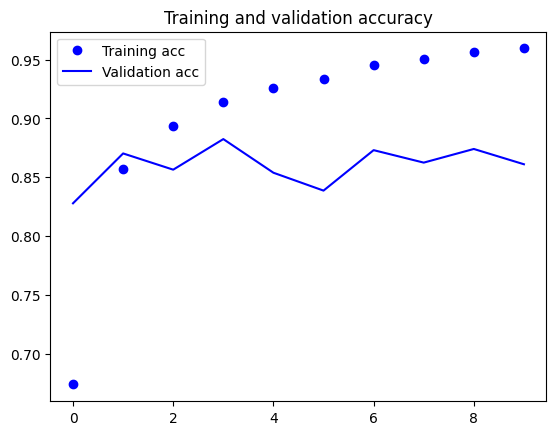

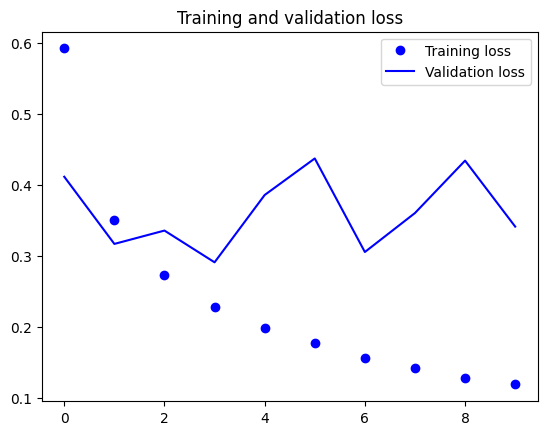

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This time, you achieve up to 89% validation accuracy. Not bad: certainly much betterthan the SimpleRNN network—that’s largely because LSTM suffers much less from the vanishing-gradient problem—and slightly better than the fully connected approach from chapter 3, even though you’re looking at less data than you were in chapter 3. You’re truncating sequences after 500 timesteps, whereas in chapter 3, you were considering full sequences.

But this result isn’t groundbreaking for such a computationally intensive
approach. Why isn’t LSTM performing better? One reason is that you made no effort to tune hyperparameters such as the embeddings dimensionality or the LSTM output dimensionality. Another may be lack of regularization. But honestly,the primary reason is that analyzing the global, long-term structure of the reviews (what LSTM is good at) isn’t helpful for a sentiment-analysis problem. Such a basic problem is well solved by looking at what words occur in each review, and at what frequency. That’s what the first fully connected approach looked at. But there are far more difficult natural-language-processing problems out there, where the strength of LSTM will become apparent: in particular, question-answering and machine translation.

Now let us evaluate the model on the test data.

In [ ]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=2,
                    batch_size=128)

print('\nEvaluate on test data')
results = model.evaluate(input_test, y_test)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
196/196 [==============================] - 30s 144ms/step - loss: 0.5525 - acc: 0.7101
Epoch 2/2
196/196 [==============================] - 18s 90ms/step - loss: 0.3360 - acc: 0.8639

Evaluate on test data
782/782 [==============================] - 6s 7ms/step - loss: 0.3005 - acc: 0.8756


## Class activity 2
x = 4 x 1 <br>
h(t) = 5 <br>
y(t) = 5 <br>
Wxh = 4 x 5 <br>
Whh = 5 x 5 <br>
Why = 5 x 5 <br>
h(t-1) = 5 <br>
bn = 5

## Class acitivity 3

(10000\*8) + 32*8 + 32*32 + 32 = 81312

## Class acitivity 4

(4 x h)\*(x + h) + 4\*h <br>
(4*2)\*(3+2) + 4\*2 = 48

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

input = Input((None, 3))
lstm = LSTM(2)(input)
model = Model(input, lstm)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 3)]         0         
                                                                 
 lstm_4 (LSTM)               (None, 2)                 48        
                                                                 
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________
